# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [4]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt

In [5]:
import itertools
from collections import Counter
from string import punctuation
from razdel import tokenize

## Датасет Meduza. Предварительная обработка

Загрузим датасет meduza. Одновременно сделаем преобразование даты из строки

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [5]:
data_meduza = pd.read_csv('../../meduza.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"', error_bad_lines=False)

b'Skipping line 47579: expected 17 fields, saw 19\n'


In [6]:
# Проверим преобразование
data_meduza.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                float64
authors               float64
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [7]:
data_meduza.shape

(71806, 16)

In [8]:
# Так выглядет датасет meduza
data_meduza.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2019-08-06 14:15:00,https://meduza.io/feature/2019/08/06/matros-ra...,-,NaN,NaN,Матрос разговаривал в казарме по видеосвязи,С марта 2019 года российским военным запрещено...,-,-,-,-,-,-,-,-,-
1,2019-08-06 14:20:00,https://meduza.io/news/2019/08/06/umerla-feshn...,-,NaN,NaN,Умерла фэшн-директор ЦУМа Алла Вербер,"Умерла фэшн-директор московского ЦУМа, вице-пр...",-,-,-,-,-,-,-,-,-
2,2019-08-06 14:10:00,https://meduza.io/feature/2019/08/06/sama-eta-...,-,NaN,NaN,Сама эта мысль казалась дурацкой: роботы-пчелы...,13 августа в издательстве «Эксмо» выходит книг...,-,-,-,-,-,-,-,-,-
3,2019-08-06 14:35:00,https://meduza.io/news/2019/08/06/u-zaderzhann...,-,NaN,NaN,У задержанных на акции за свободные выборы 3 а...,"Некоторые участникиnакции 3 августаn, у которы...",-,-,-,-,-,-,-,-,-
4,2019-08-06 15:00:00,https://meduza.io/feature/2019/08/06/pochemu-v...,-,NaN,NaN,Почему ваш товар плохо продается в интернете?,"Интернет-покупатели становятся все капризнее, ...",-,-,-,-,-,-,-,-,-


In [9]:
# Выясним в каким столбцах есть пустые данные
data_meduza.isnull().any()

date           False
url            False
edition        False
topics          True
authors         True
title           True
text            True
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

In [10]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_meduza['text'].isnull().sum())
data_meduza[data_meduza['text'].isnull()].head()

Кол-во строк с значением NaN в столбце "Text" =  1372


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
33,2019-08-06 10:53:00,https://meduza.io/quiz/otlichite-kachestvennyy...,-,NaN,NaN,NaN,NaN,-,-,-,-,-,-,-,-,-
86,2019-08-05 14:41:00,https://meduza.io/quiz/moscow-is-the-capital-o...,-,NaN,NaN,NaN,NaN,-,-,-,-,-,-,-,-,-
173,2019-08-02 13:05:00,https://meduza.io/quiz/kostyl-ili-chekvarka,-,NaN,NaN,NaN,NaN,-,-,-,-,-,-,-,-,-
194,2019-08-02 05:30:00,https://meduza.io/quiz/chto-obsuzhdayut-na-ros...,-,NaN,NaN,NaN,NaN,-,-,-,-,-,-,-,-,-
250,2019-08-01 08:39:00,https://meduza.io/games/v-rossii-mogut-oshtraf...,-,NaN,NaN,NaN,NaN,-,-,-,-,-,-,-,-,-


In [11]:
#Удалим эти строки
data_meduza.drop(data_meduza[data_meduza.text.isnull()].index, inplace=True)

In [12]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_meduza['text'].isnull().sum())

Кол-во строк с значением NaN в столбце "Text" =  0


Посмотрим сколько элементов Nan в столбце авторов

In [13]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_meduza['authors'].isnull().sum())

Кол-во строк с значением NaN в столбце "authors" =  70434


Как видим все значения авторов Nan. Можно не использовать данные столбец

Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [14]:
def analysis_columns(columns):
    for column in columns:
        if column not in ['url', 'date', 'topics', 'authors', 'title', 'text']:
            yield(print(str(column) + ':', data_meduza[column].unique()))

In [15]:
data_columns = list(analysis_columns(data_meduza.columns))

edition: ['-']
reposts_fb: ['-']
reposts_vk: ['-']
reposts_ok: ['-']
reposts_twi: ['-']
reposts_lj: ['-']
reposts_tg: ['-']
likes: ['-']
views: ['-']
comm_count: ['-']


Можно удалить все эти столбцы

In [16]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_meduza.text.duplicated().sum())

Кол-во одинаковых текстов: 11


In [17]:
data_meduza = data_meduza.drop_duplicates(subset='text')

In [18]:
data_meduza.shape

(70423, 16)

## EDA

### Анализ дат

In [19]:
print('Минимальная дата в датасете:', data_meduza.date.min())
print('Максимальная дата в датасете:', data_meduza.date.max())

Минимальная дата в датасете: 2014-09-12 09:04:00
Максимальная дата в датасете: 2019-08-07 05:28:00


#### Распределение количества новостей по месяцам

In [20]:
# Вынесем месяц и год новости в отдельные столбцы
data_meduza['month'] = data_meduza.date.apply(lambda x: x.month)
data_meduza['year'] = data_meduza.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data_meduza.groupby(['year', 'month']).text.nunique().reset_index()

In [21]:
df.head()

,year,month,text
0,2014,9,1
1,2014,10,659
2,2014,11,1044
3,2014,12,1268
4,2015,1,921


In [22]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [23]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [24]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [25]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head()

,month_year,nunique_text
19,04-2016,1414
18,03-2016,1398
22,07-2016,1392
30,03-2017,1388
23,08-2016,1377


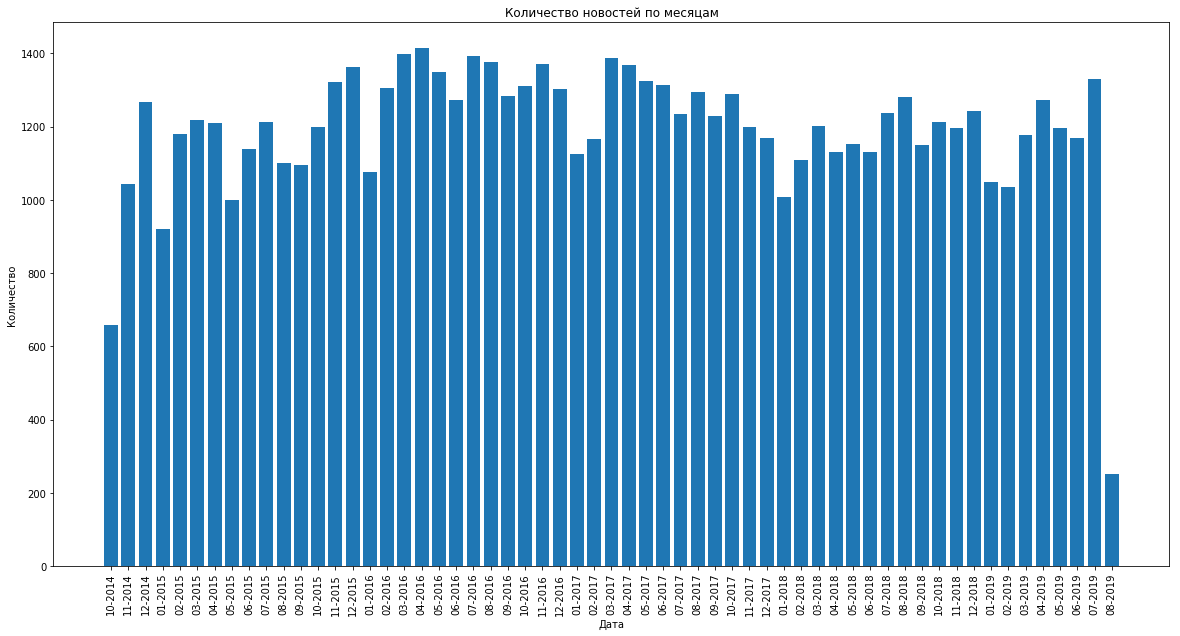

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
ax.set_title('Количество новостей по месяцам')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
plt.show()

### Создание словаря для анализа

В данной части блокнота будет подготовлен словарь из всего множества слов во всем датасете. Для каждой новости будет выполнена токенизация. Затем будет собран словарь из всех токенов, очистка от знаков препинания, и после данных процедур создается два списка - один без удаления стоп-слов, второй с удалением. Анализ проводится по частоте вхождений для каждого списка

In [27]:
def create_dictionary(text):
    for news in text:
        tokens = list(tokenize(news.lower()))
        yield([_.text for _ in tokens])

In [28]:
data_meduza.text = list(create_dictionary(data_meduza.text.values))

In [29]:
# Соберем словарь из новостей для последующего анализа, без объединения повторяющихся слов
dictionary = list(itertools.chain.from_iterable(data_meduza.text.values))

In [ ]:
# Соберем значки препинания, часть возьмем из готовой библиотеки, часть добавим свои

In [30]:
punctuation = list(punctuation)

In [42]:
punctuation += ['«','»','—','n','»,','».','–', '...','“', '„']

In [43]:
garbage_words = ['nранее', 'nв', 'nпо', 'nтакже','u','n—']

In [44]:
# Словарь без удаления стопслов
dictionary_with_stopwords = [item for item in dictionary if item not in punctuation]

In [45]:
dictionary_with_stopwords = [item for item in dictionary_with_stopwords if item not in garbage_words]

In [46]:
stopwords_01 = open('../nlp/preprocessing/stopwords.txt', 'r', encoding='UTF-8')
stopwords_01 = stopwords_01.read().split('\n')
stopwords_02 = open('../nlp/preprocessing/stopwords_02.txt', 'r', encoding='UTF-8')
stopwords_02 = stopwords_02.read().split('\n')

In [47]:
stopwords = stopwords_01 + stopwords_02

In [48]:
# Словарь после удаления стопслов
dictionary_without_stopwords = [item for item in dictionary_with_stopwords if item not in stopwords]

### Аналитика по словам

#### 20 самых популярных слов без удаления стопслов

In [49]:
Counter(dictionary_with_stopwords).most_common(20)

[('в', 941891),
 ('и', 547594),
 ('на', 380610),
 ('что', 282942),
 ('не', 281648),
 ('с', 246772),
 ('по', 194589),
 ('о', 115382),
 ('из', 115299),
 ('это', 108186),
 ('как', 104513),
 ('а', 103405),
 ('он', 95932),
 ('к', 95468),
 ('за', 90182),
 ('его', 86484),
 ('но', 84365),
 ('года', 79514),
 ('я', 76063),
 ('у', 74925)]

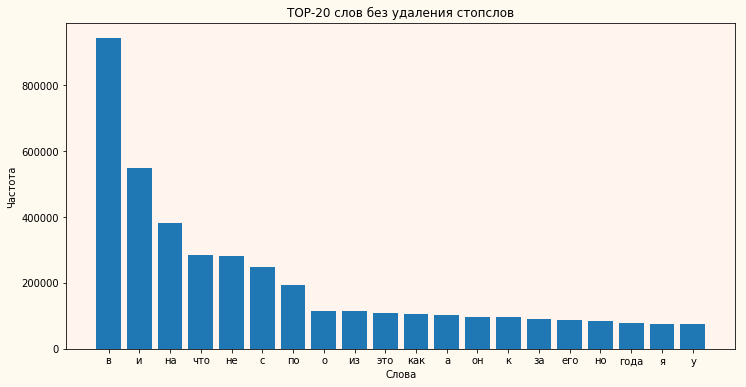

In [50]:
x = dict(Counter(dictionary_with_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_with_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

#### 20 самых популярных слов после удаления стопслов 

In [51]:
Counter(dictionary_without_stopwords).most_common(20)

[('россии', 51782),
 ('рф', 24051),
 ('сша', 23941),
 ('словам', 22038),
 ('рублей', 20688),
 ('заявил', 20194),
 ('из-за', 18195),
 ('2015', 16385),
 ('2016', 16333),
 ('данным', 16151),
 ('компании', 15966),
 ('людей', 15044),
 ('власти', 14471),
 ('например', 14214),
 ('президента', 14177),
 ('числе', 13784),
 ('2014', 13078),
 ('человека', 12368),
 ('решение', 12152),
 ('сообщил', 12033)]

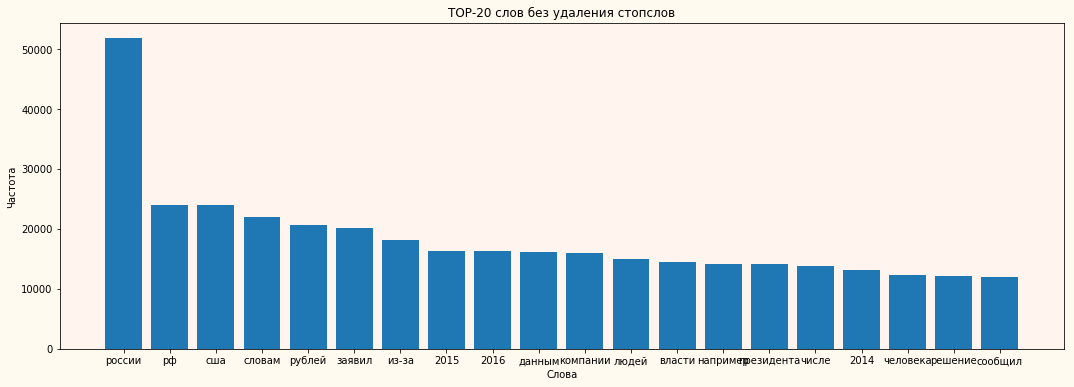

In [52]:
x = dict(Counter(dictionary_without_stopwords).most_common(20)).keys()
y = dict(Counter(dictionary_without_stopwords).most_common(20)).values()

fig, ax = plt.subplots()

ax.bar(x, y)
ax.set_title('TOP-20 слов без удаления стопслов')
ax.set_ylabel('Частота')
ax.set_xlabel('Слова')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure


plt.show()

### Рубрики Meduza


In [54]:
# Считаем количество рубрик в датасете Ria, а также выведем значения
print('Количество рубрик = ', data_meduza.topics.unique().shape)
data_meduza['topics'].unique()

Количество рубрик =  (1,)


array([nan])

In [55]:
data_meduza.groupby('topics')['topics'].count().head()

Series([], Name: topics, dtype: int64)